






























































































































# Importing packages 

In [1]:
# Data wrangling 
import pandas as pd 

# Array math
import numpy as np 

# Ploting 
import seaborn as sns
import matplotlib.pyplot as plt

# List iteration tracking
from tqdm import tqdm

# Motivating example

Lets load some data from the famous titanic dataset.

In [2]:
# Loading data
d = pd.read_csv('data/train.csv')

In [3]:
d.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
344,345,0,2,"Fox, Mr. Stanley Hubert",male,36.00,0,0,229236,13.0000,NaN,S
443,444,1,2,"Reynaldo, Ms. Encarnacion",female,28.00,0,0,230434,13.0000,NaN,S
449,450,1,1,"Peuchen, Major. Arthur Godfrey",male,52.00,0,0,113786,30.5000,C104,S
12,13,0,3,"Saundercock, Mr. William Henry",male,20.00,0,0,A/5. 2151,8.0500,NaN,S
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S
303,304,1,2,"Keane, Miss. Nora A",female,NaN,0,0,226593,12.3500,E101,Q
522,523,0,3,"Lahoud, Mr. Sarkis",male,NaN,0,0,2624,7.2250,NaN,C
384,385,0,3,"Plotcharsky, Mr. Vasil",male,NaN,0,0,349227,7.8958,NaN,S
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
767,768,0,3,"Mangan, Miss. Mary",female,30.50,0,0,364850,7.7500,NaN,Q


Lets say we want to create a classifier whether a passenger survived or not using two variables: age and fare (price for a ticket). We want to create a simple decision tree to accomplish this task. 

In [4]:
dd = d[['Survived', 'Fare', 'Age']].copy()

# Droping missing entries
dd.dropna(inplace=True)

In [5]:
print(f"Number of observations: {dd.shape[0]}")

Number of observations: 714


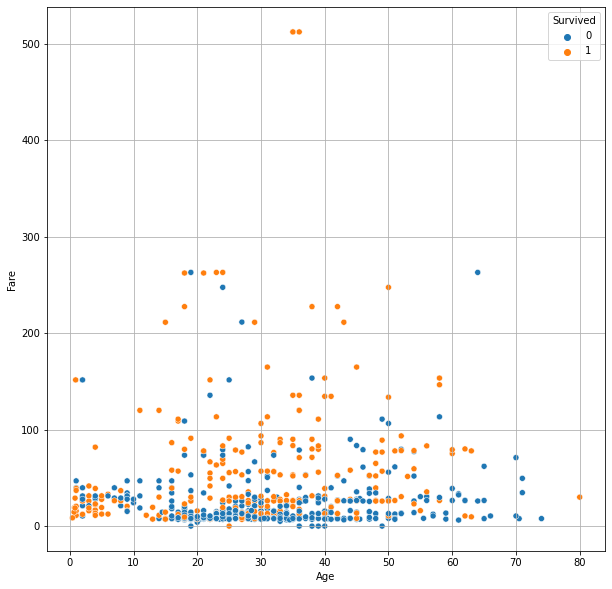

In [6]:
plt.figure(figsize=(10, 10))
sns.scatterplot(y='Fare', x='Age', data=dd, hue='Survived')
plt.grid()
plt.show()

Every decision tree creation starts with the selection of what variable and what value we should choose to split? 

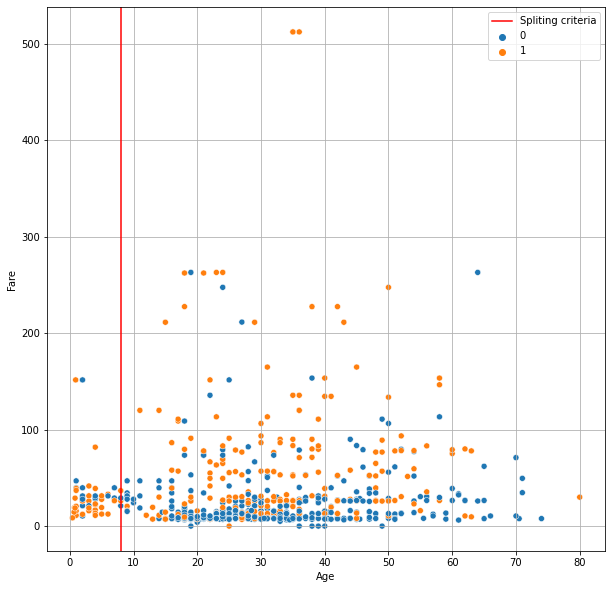

In [7]:
# Define the split value 
age_split = 8 

# Ploting the original plot
plt.figure(figsize=(10, 10))
sns.scatterplot(y='Fare', x='Age', data=dd, hue='Survived')
plt.grid()

# Adding the vertical line
plt.axvline(age_split, label='Spliting criteria', color='red')
plt.legend()
plt.show()

In [8]:
# Getting the left and right datasets
left = dd[dd['Age']<=age_split]
right = dd[dd['Age']>age_split]

We made a decision to split the data into two parts based on the visual ques from the scatterplot. Some statistics:

In [9]:
print(f"Observations to the left of criteria: {left.shape[0]}")
print(f"Observations to the right of criteria: {right.shape[0]}")

Observations to the left of criteria: 54
Observations to the right of criteria: 660


In [10]:
left.groupby('Survived', as_index=False).size()

,Survived,size
0,0,18
1,1,36


In [11]:
right.groupby('Survived', as_index=False).size()

,Survived,size
0,0,406
1,1,254


There are observations from both of the classes in the nodes. Thus, each of the nodes are are **impure**. But how impure? To measure impurity we use the **GINI** impurity coefficient. 

# GINI impurity definition 

The GINI impurity index is the default spliting criteria when building decision trees. 

The formal definition for GINI impurity is as follows: 
    
*Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset.*

The definition is not very intuitive so lets bring some clarity. 

Suppose we have two classes in the dataset:

$$k_{1}, k_{2}$$. 

Each of the classes have $n_{1}$ and $n_{2}$ observations.

The probability of observing something from one of the $k$ classes is: 

$$p(i) = P(x_{i} \in k_{i}) = \dfrac{n_{i}}{n_{1} + n_{2}},  i \in \{1, 2\}$$

The GINI impurity of such a system is calculated with the following formula:
    
$$G = 1 - \Sigma_{i=1}^{2}p(i)^{2}$$

In [12]:
def GINI_impurity(y1_count, y2_count):
    """
    Given the observations of a binary class calculate the GINI impurity
    """
    # Getting the total observations
    n = y1_count + y2_count
    
    # Getting the probability to see each of the classes
    p1 = y1_count / n
    p2 = y2_count / n
    
    # Calculating GINI 
    gini = 1 - (p1 ** 2 + p2 ** 2)
    
    # Returning the gini impurity
    return gini

In [13]:
# Simulating some data
n = 1000

shares_y1 = [
    0, 
    0.1,
    0.2,
    0.3,
    0.4,
    0.5, 
    0.6,
    0.7,
    0.8,
    0.9,
    1
] 

y1_counts = [x * n for x in shares_y1]
y2_counts = [n - x for x in y1_counts]

y = list(zip(y1_counts, y2_counts))

In [14]:
y

[(0, 1000),
 (100.0, 900.0),
 (200.0, 800.0),
 (300.0, 700.0),
 (400.0, 600.0),
 (500.0, 500.0),
 (600.0, 400.0),
 (700.0, 300.0),
 (800.0, 200.0),
 (900.0, 100.0),
 (1000, 0)]

In [15]:
# Getting the GINI impurities for such data
ginis = [GINI_impurity(x[0], x[1]) for x in y]

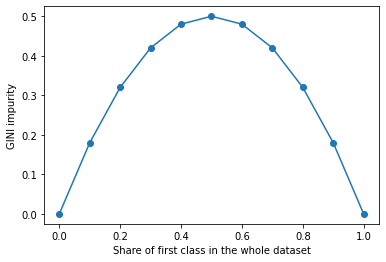

In [16]:
plt.plot(shares_y1, ginis, '-o')
plt.xlabel("Share of first class in the whole dataset")
plt.ylabel("GINI impurity")
plt.show()

The above graph shows a very important relationship. The upper bound of the GINI impurity index is 0.5. It occurs when there is an equal number of observations of each class in the dataset. This is the **worst** case in terms of GINI impurity.

At the edges of graph, we get that impurity is 0. This occurs when there is only one class in the data. This is the **best** situation. 

# GINI impurity of a split 

Going back to the example with the titanic dataset, we have two datasets resulting from the chosen split. Each of the datasets have different GINI impurity indexes. 

In [17]:
left_counts = left.groupby("Survived").size().values.tolist()
right_counts = right.groupby("Survived").size().values.tolist()

gini_left = GINI_impurity(left_counts[0], left_counts[1])
gini_right = GINI_impurity(right_counts[0], right_counts[1])

In [18]:
print(f"Gini impurity of the left node: {gini_left}")
print(f"Gini impurity of the right node: {gini_right}")

Gini impurity of the left node: 0.4444444444444444
Gini impurity of the right node: 0.4734802571166208


The final GINI impurity index is calculated using the weighted average based on the observation sizes in each of the datasets.

In [19]:
w1 = left.shape[0]/ (left.shape[0] + right.shape[0]) 
w2 = right.shape[0] / (left.shape[0] + right.shape[0]) 

In [20]:
gini_final = w1 * gini_left + w2 * gini_right

In [21]:
print(f"Final gini impurity: {gini_final}")

Final gini impurity: 0.4712842712842713


In [22]:
def GINI_impurity_df_split(
    df:pd.DataFrame, 
    target, 
    split_X, 
    split_value,
    min_n=10
):
    """
    Function to calculate the resulting GINI impurity of a split
    """
    # Getting the left and right nodes
    left = df[df[split_X] <= split_value]
    right = df[df[split_X] > split_value]
    
    if (min_n > left.shape[0]) or (min_n > right.shape[0]):
        return 0.5
    
    # Getting the counts and ginis
    left_counts = left.groupby(target).size().values.tolist()
    right_counts = right.groupby(target).size().values.tolist()

    gini_left = GINI_impurity(left_counts[0], left_counts[1])
    gini_right = GINI_impurity(right_counts[0], right_counts[1])
    
    # Getting the final weighted GINI impurity
    w1 = left.shape[0]/ (left.shape[0] + right.shape[0]) 
    w2 = right.shape[0] / (left.shape[0] + right.shape[0]) 
    
    return w1 * gini_left + w2 * gini_right

# GINI gain

The last metric used in deciding where to split the data is the GINI gain metric. Its calculated by the difference of non splited GINI of the dataset and the GINI of the selected split. 

In [23]:
def GINI_impurity_df(df:pd.DataFrame, target):
    """
    Function to calculate the resulting GINI impurity of a split
    """
    # Getting the counts and ginis
    counts = df.groupby(target).size().values.tolist()

    gini = GINI_impurity(counts[0], counts[1])
    
    return gini

In [24]:
gini_orig = GINI_impurity_df(dd, 'Survived')
gini_split = GINI_impurity_df_split(dd, 'Survived', 'Age', 8)

In [25]:
print(f"Gini non-splited: {gini_orig}")
print(f"Gini with the proposed split: {gini_split}")
print(f"Gini gain: {gini_orig - gini_split}")

Gini non-splited: 0.48238903404499056
Gini with the proposed split: 0.4712842712842713
Gini gain: 0.011104762760719256


At each split decision, we chose that split that has the highest GINI gain. If the GINI gain is non positive, we do not perform the split.

# Spliting on numeric variables 


When deciding where to split a numeric feature, we first sort all the values, get the means between neighbouring values and calculate the GINI gains. 

In [26]:
values = dd['Age'].sort_values().rolling(2).mean()

# Droping NA 
values = values.dropna()

# Geting the unsplited GINI
gini_orig = GINI_impurity_df(dd, 'Survived')

# Gains 
ginis = []

for value in tqdm(values):
    # Getting all the ginis
    ginis.append(GINI_impurity_df_split(dd, 'Survived', 'Age', value))
    
# Calculating the gains
gains = [gini_orig - gini for gini in ginis]

# Getting best age split
best_age_split = values[np.where(gains == np.max(gains))[0][0]]
best_age_gini_gain = np.max(gains)

100%|██████████████████████████████████████████████████████████████████████████████| 713/713 [00:00<00:00, 1235.42it/s]


In [27]:
values = dd['Fare'].sort_values().rolling(2).mean()

# Droping NA 
values = values.dropna()

# Geting the unsplited GINI
gini_orig = GINI_impurity_df(dd, 'Survived')

# Gains 
ginis = []

for value in tqdm(values):
    # Getting all the ginis
    ginis.append(GINI_impurity_df_split(dd, 'Survived', 'Fare', value))
    
# Calculating the gains
gains = [gini_orig - gini for gini in ginis]

# Getting best age split
best_fare_split = values[np.where(gains == np.max(gains))[0][0]]
best_fare_gini_gain = np.max(gains)

100%|██████████████████████████████████████████████████████████████████████████████| 713/713 [00:00<00:00, 1239.72it/s]


In [28]:
print(f'Best age split: {best_age_split}. GINI gain: {best_age_gini_gain}.')
print(f'Best fare split: {best_fare_split}. GINI gain: {best_fare_gini_gain}.')

Best age split: 19.0. GINI gain: 0.0123447785042467.
Best fare split: 7.925. GINI gain: 0.046911102092441426.


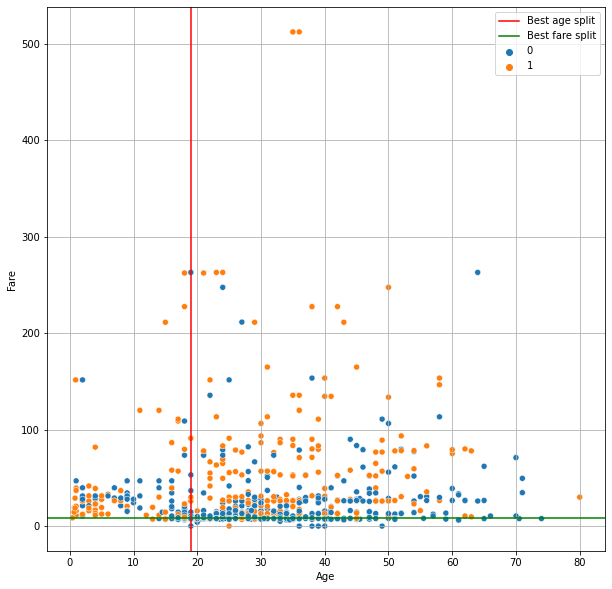

In [29]:
# Define the split value 
age_split = 8 

# Ploting the original plot
plt.figure(figsize=(10, 10))
sns.scatterplot(y='Fare', x='Age', data=dd, hue='Survived')
plt.grid()

# Adding the vertical line
plt.axvline(best_age_split, label='Best age split', color='red')
plt.axhline(best_fare_split, label='Best fare split', color='green')
plt.legend()
plt.show()